In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from akita_utils.format_io import h5_to_df
from scipy import stats

In [2]:
import sys
sys.path.insert(0, "/home1/smaruj/akitaX1-analyses/utils/")
from utils import (read_and_average_genomic_exp, average_stat_over_targets, average_stat_over_backgrounds)

2024-01-22 16:21:55.670993: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-22 16:21:55.705498: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-22 16:21:55.705552: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-22 16:21:55.706492: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-22 16:21:55.713566: I tensorflow/core/platform/cpu_feature_guar

In [3]:
# for all directories with results:
# python collect_jobs_and_clean.py /scratch2/smaruj/<directory> -g -l -n

In [4]:
# stat metric the analysis is based on
stat_of_analysis_interest = "SCD"

In [5]:
data_dir = "/project/fudenber_735/akitaX1_analyses_data/genomic_disruption_experiment/disruption_by_permutation"

In [6]:
# reading data, averaging over targets
df = read_and_average_genomic_exp(data_dir, stat_to_average=stat_of_analysis_interest)

reading h5 files to dataframes
averaging over targets
collecting data for SCD


In [7]:
# reading additional permutation for model 0
df_m0_perm = h5_to_df(data_dir+"/model_0_perm.h5", ["SCD", "INS-16", "INS-64"], average=False)
df_m0_perm_tg = average_stat_over_targets(df_m0_perm, model_index=0, head_index=1, stat=stat_of_analysis_interest)

## Disruption scores for specific sites are correlated across random motif permutations

Text(0, 0.5, 'ave SCD model 0, perm 2')

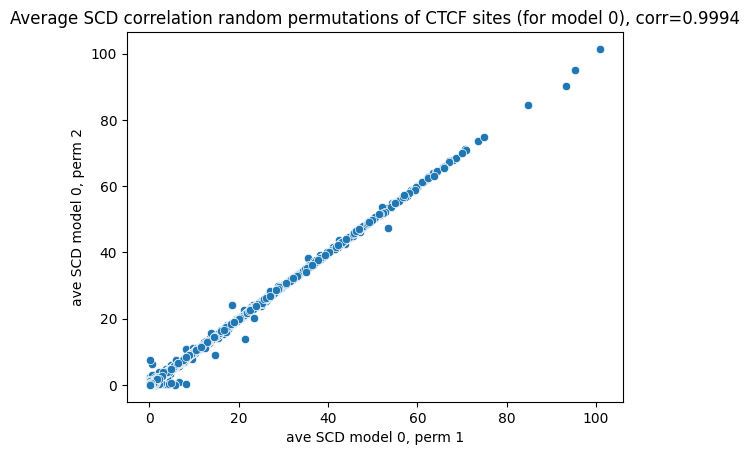

In [8]:
sn.scatterplot(x=df[f"{stat_of_analysis_interest}_m0"], y=df_m0_perm_tg[f"{stat_of_analysis_interest}_m0"])
perm_corr = round(stats.pearsonr(df[f"{stat_of_analysis_interest}_m0"], df_m0_perm_tg[f"{stat_of_analysis_interest}_m0"]).statistic, 4)
plt.title(f"Average {stat_of_analysis_interest} correlation random permutations of CTCF sites (for model 0), corr={perm_corr}")
plt.xlabel(f"ave {stat_of_analysis_interest} model 0, perm 1")
plt.ylabel(f"ave {stat_of_analysis_interest} model 0, perm 2")

## Correlations between models

Text(0, 0.5, 'ave SCD model 1')

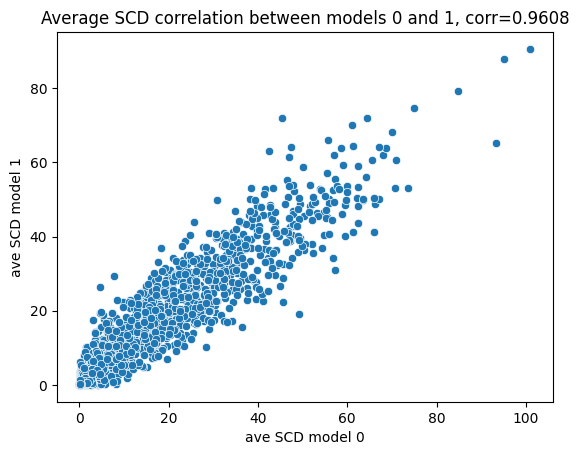

In [9]:
sn.scatterplot(x=df[f"{stat_of_analysis_interest}_m0"], y=df[f"{stat_of_analysis_interest}_m1"])
m0_m1_corr = round(stats.pearsonr(df[f"{stat_of_analysis_interest}_m0"], df[f"{stat_of_analysis_interest}_m1"]).statistic, 4)
plt.title(f"Average {stat_of_analysis_interest} correlation between models 0 and 1, corr={m0_m1_corr}")
plt.xlabel(f"ave {stat_of_analysis_interest} model 0")
plt.ylabel(f"ave {stat_of_analysis_interest} model 1")

## Correlations between all models

Text(0.5, 0.98, 'Correlations of SCD between models')

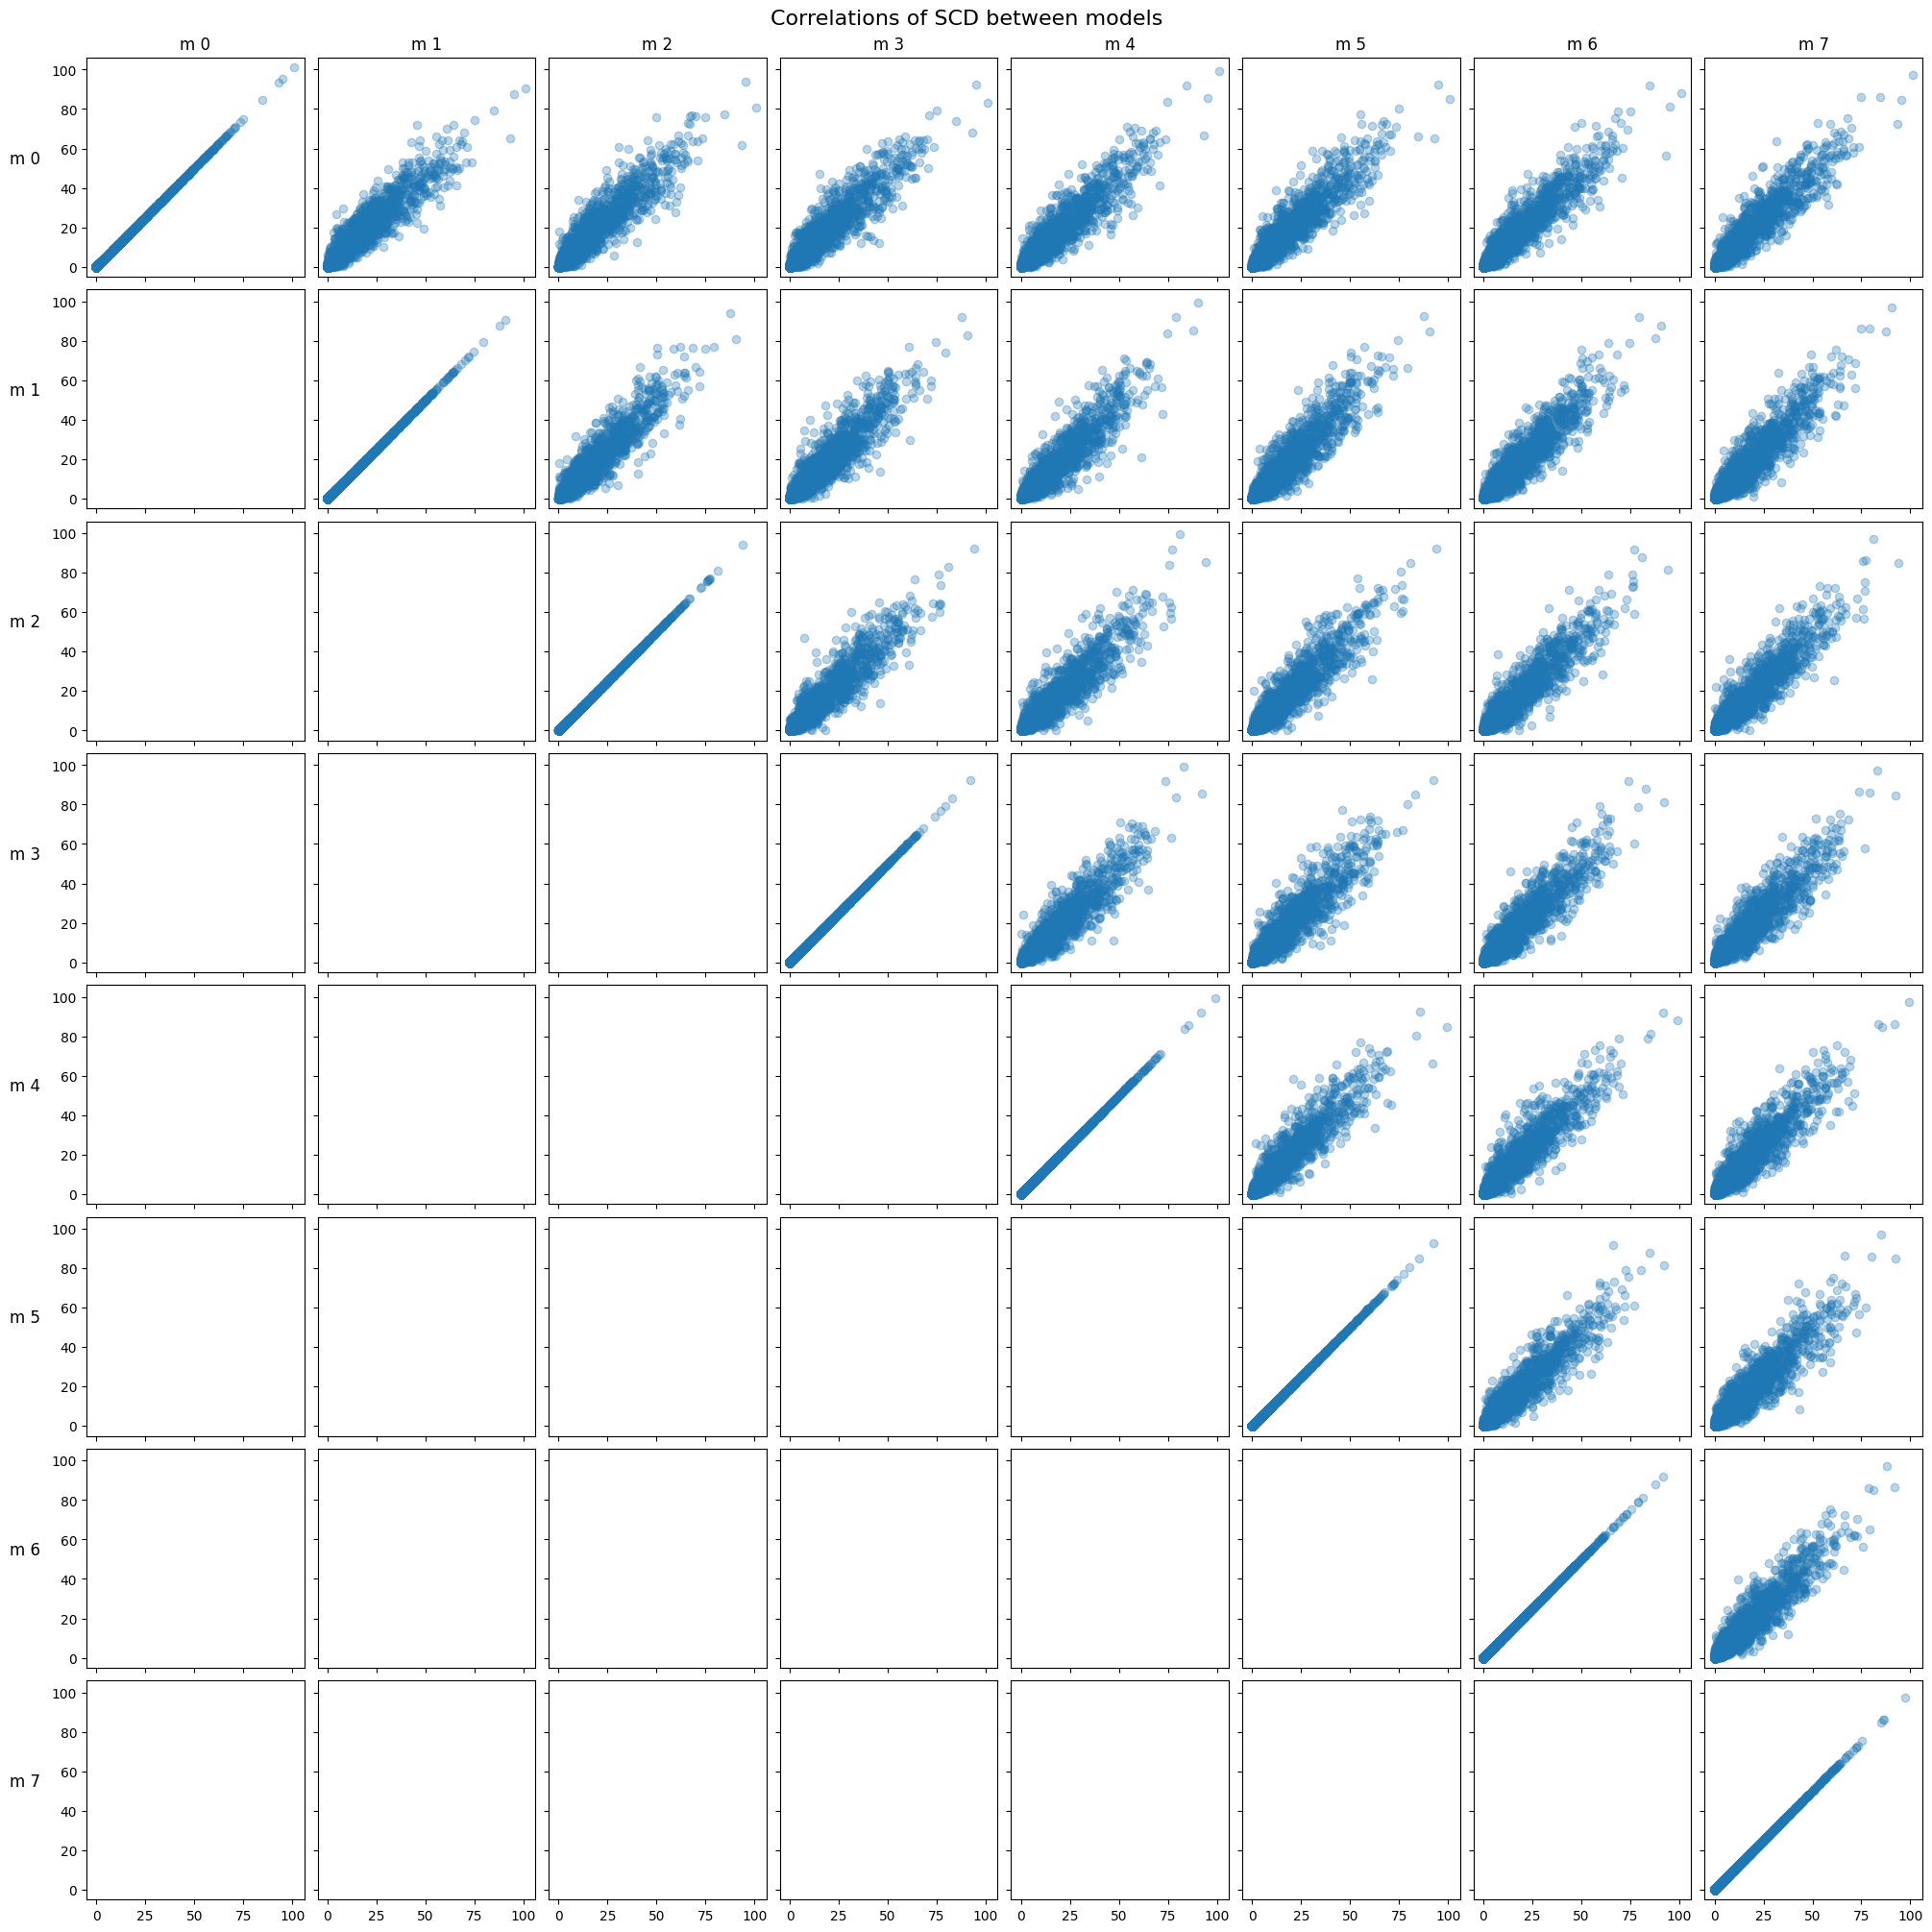

In [10]:
num_models = 8

models_corr_summary = np.zeros((num_models,num_models))

fig, axs = plt.subplots(num_models, num_models, figsize=(20, 20), sharex=True, sharey=True, layout="constrained")

for model_index_x in range(num_models):
    for model_index_y in range(num_models):
        if (model_index_y >= model_index_x):
            
            stat_x = np.array(df[f"{stat_of_analysis_interest}_m{model_index_x}"])
            stat_y = np.array(df[f"{stat_of_analysis_interest}_m{model_index_y}"])
            
            axs[model_index_x, model_index_y].scatter(x=stat_x, y=stat_y, alpha=0.3)
            
            models_corr_summary[model_index_x, model_index_y] = models_corr_summary[model_index_y, model_index_x] = stats.pearsonr(stat_x, stat_y).statistic
            
names = [f"m {i}" for i in range(num_models)]

for ax, col in zip(axs[0], names):
    ax.set_title(col, size=12)

for ax, row in zip(
    axs[:, 0],
    names,
):
    ax.set_ylabel(row, rotation=0, fontsize=12, labelpad=20)
    
fig.suptitle(f"Correlations of {stat_of_analysis_interest} between models", fontsize=16)

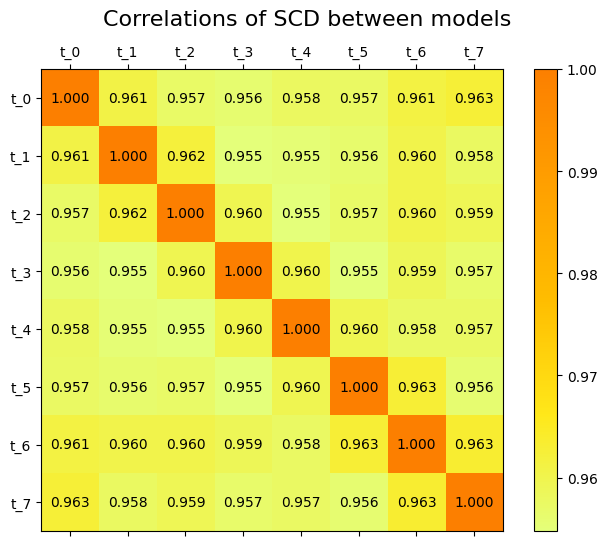

In [11]:
fig = plt.figure(figsize=(8, 6))

ax = fig.add_subplot(111)
cax = ax.matshow(models_corr_summary, cmap="Wistia", interpolation='nearest')
fig.colorbar(cax)

names = [f"t_{i}" for i in range(num_models)]

xaxis = np.arange(len(names))
ax.set_xticks(xaxis)
ax.set_yticks(xaxis)
ax.set_xticklabels(names)
ax.set_yticklabels(names)

for (x, y), value in np.ndenumerate(models_corr_summary):
    plt.text(x, y, f"{value:.3f}", va="center", ha="center")

fig.suptitle(f"Correlations of {stat_of_analysis_interest} between models", fontsize=16)

fig.show()

## Correlations between targets for model 0

Text(0.5, 0.98, 'Correlations of SCD between targets')

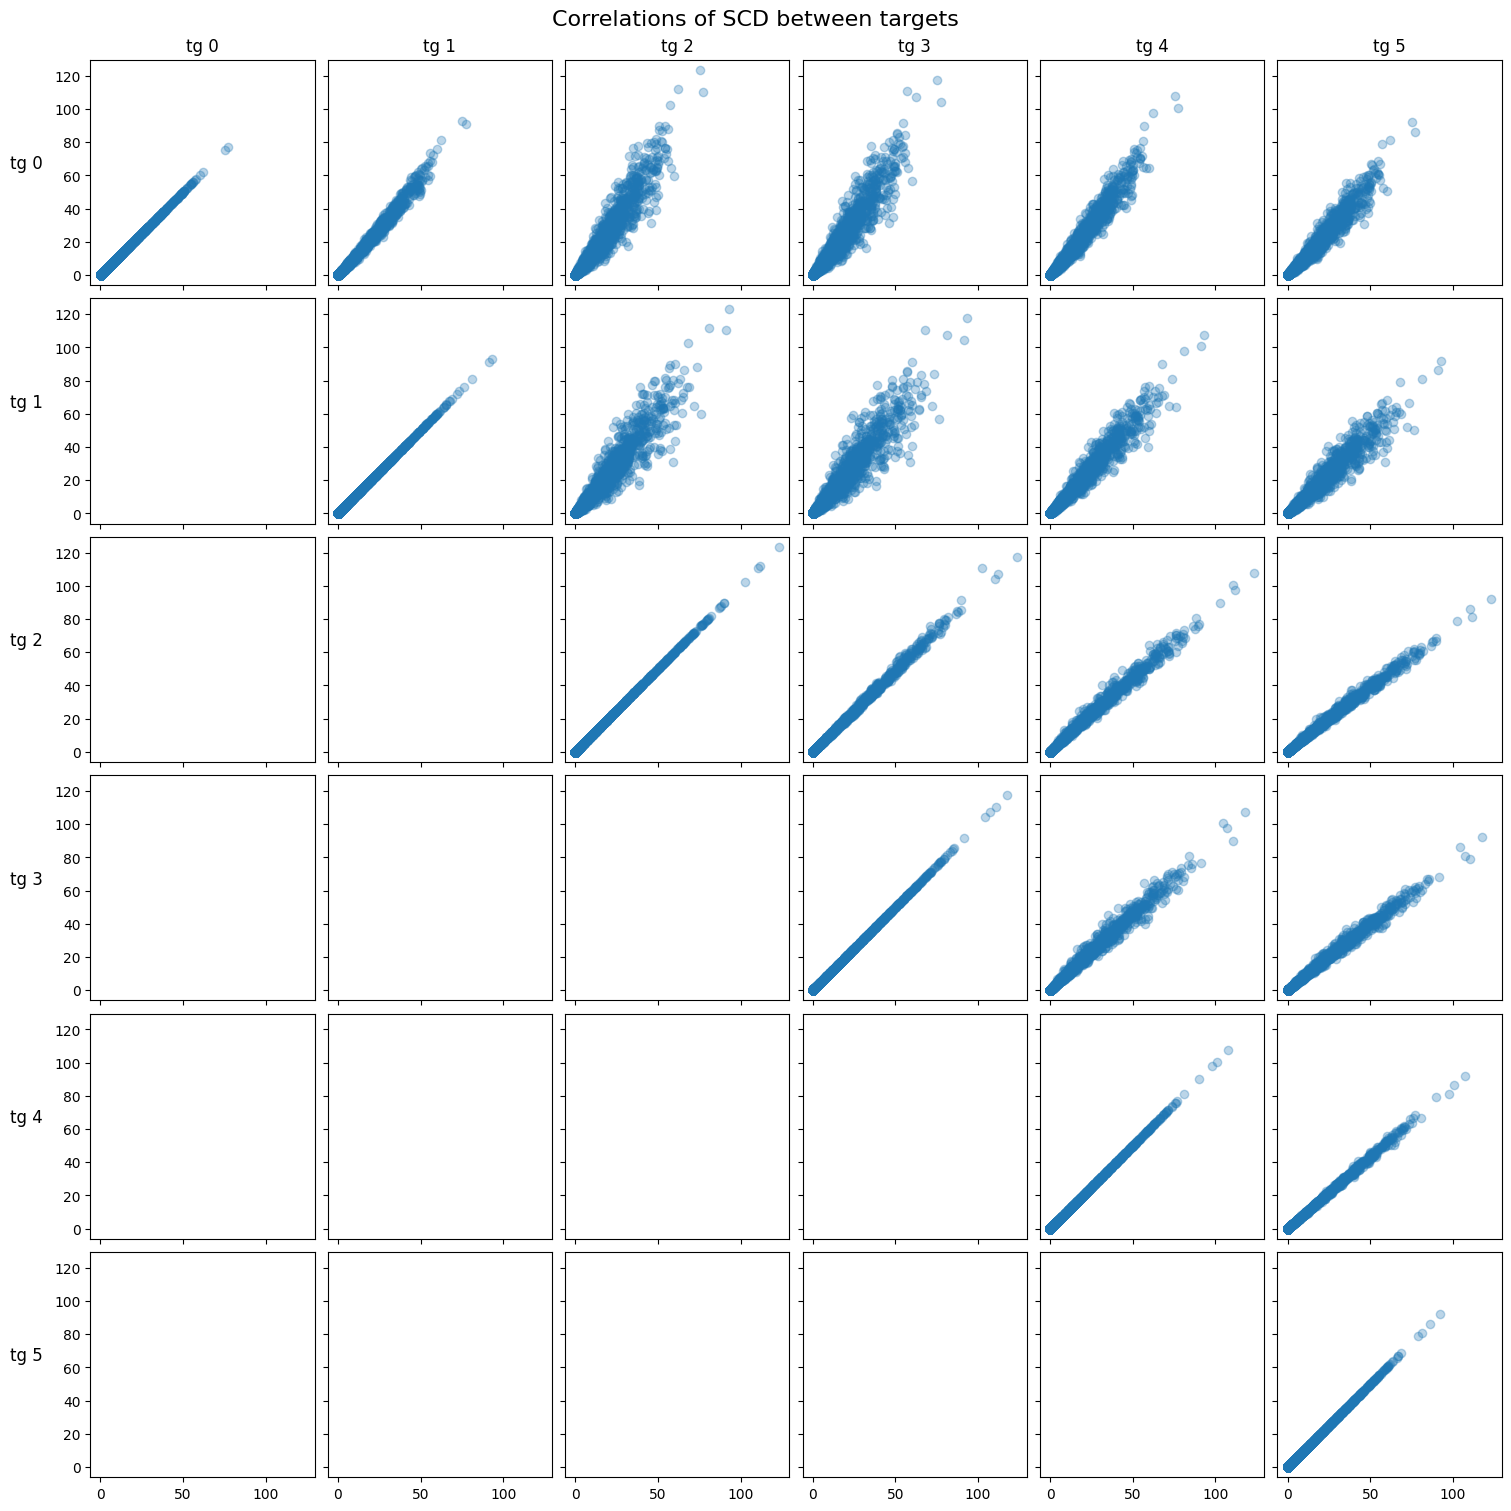

In [12]:
num_targets = 6
model_index = 0
targets_corr_summary = np.zeros((num_targets, num_targets))

fig, axs = plt.subplots(num_targets, num_targets, figsize=(15, 15), sharex=True, sharey=True, layout="constrained")

for target_index_x in range(num_targets):
    for target_index_y in range(num_targets):
        if (target_index_y >= target_index_x):
            
            stat_x = np.array(df_m0_perm_tg[f"{stat_of_analysis_interest}_h1_m{model_index}_t{target_index_x}"])
            stat_y = np.array(df_m0_perm_tg[f"{stat_of_analysis_interest}_h1_m{model_index}_t{target_index_y}"])
            
            axs[target_index_x, target_index_y].scatter(x=stat_x, y=stat_y, alpha=0.3)
            
            targets_corr_summary[target_index_x, target_index_y] = targets_corr_summary[target_index_y, target_index_x] = stats.pearsonr(stat_x, stat_y).statistic
            
names = [f"tg {i}" for i in range(num_targets)]

for ax, col in zip(axs[0], names):
    ax.set_title(col, size=12)

for ax, row in zip(
    axs[:, 0],
    names,
):
    ax.set_ylabel(row, rotation=0, fontsize=12, labelpad=20)
    
fig.suptitle(f"Correlations of {stat_of_analysis_interest} between targets", fontsize=16)

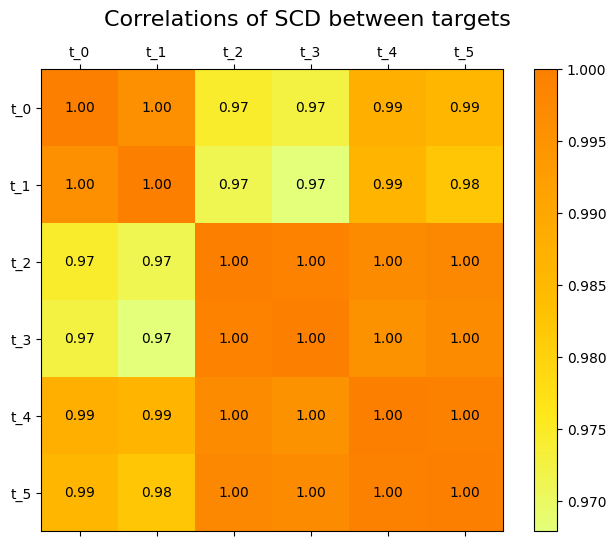

In [13]:
fig = plt.figure(figsize=(8, 6))

ax = fig.add_subplot(111)
cax = ax.matshow(targets_corr_summary, cmap="Wistia", interpolation='nearest')
fig.colorbar(cax)

names = [f"t_{i}" for i in range(num_targets)]

xaxis = np.arange(len(names))
ax.set_xticks(xaxis)
ax.set_yticks(xaxis)
ax.set_xticklabels(names)
ax.set_yticklabels(names)

for (x, y), value in np.ndenumerate(targets_corr_summary):
    plt.text(x, y, f"{value:.2f}", va="center", ha="center")

fig.suptitle(f"Correlations of {stat_of_analysis_interest} between targets", fontsize=16)

fig.show()